In [1]:
# ------------------------------
# 0. Setup
# ------------------------------
import mne
import numpy as np
import matplotlib.pyplot as plt

# Path to your processed data
clean_file = "../data/processed/A01T_clean.fif"

# Load the preprocessed raw data
raw_clean = mne.io.read_raw_fif(clean_file, preload=True)
print(raw_clean)

Opening raw data file ../data/processed/A01T_clean.fif...


C:\Users\steve\AppData\Local\Temp\ipykernel_16452\826551902.py:12: RuntimeWarning: This filename (../data/processed/A01T_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(clean_file, preload=True)


    Read a total of 1 projection items:
        Average EEG reference (1 x 22) active
    Range : 0 ... 672527 =      0.000 ...  2690.108 secs
Ready.
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...
<Raw | A01T_clean.fif, 25 x 672528 (2690.1 s), ~128.3 MiB, data loaded>


In [20]:
# ------------------------------
# 1. Extract events & auto-map IDs
# ------------------------------
events, event_id_map = mne.events_from_annotations(raw_clean)
print("Full event dict from MNE:\n", event_id_map)
print("Unique event codes in events:", np.unique(events[:, -1]))

# Keep only motor imagery events (769–772)
motor_codes = ["769", "770", "771", "772"]
event_ids = {name: event_id_map[code] for name, code in zip(
    ["left_hand", "right_hand", "foot", "tongue"], motor_codes
) if code in event_id_map}

print("Filtered motor imagery event_ids:\n", event_ids)



Used Annotations descriptions: [np.str_('1023'), np.str_('1072'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770'), np.str_('771'), np.str_('772')]
Full event dict from MNE:
 {np.str_('1023'): 1, np.str_('1072'): 2, np.str_('276'): 3, np.str_('277'): 4, np.str_('32766'): 5, np.str_('768'): 6, np.str_('769'): 7, np.str_('770'): 8, np.str_('771'): 9, np.str_('772'): 10}
Unique event codes in events: [ 1  2  3  4  5  6  7  8  9 10]
Filtered motor imagery event_ids:
 {'left_hand': 7, 'right_hand': 8, 'foot': 9, 'tongue': 10}


In [21]:
# ------------------------------
# 2. Epoching with automatic rejection
# ------------------------------
tmin, tmax = 0.0, 4.0  

# Define rejection thresholds (in Volts)
reject_criteria = dict(
    eeg=150e-6,   # 150 µV
    eog=250e-6    # 250 µV
)

epochs = mne.Epochs(
    raw_clean,
    events,
    event_id=event_ids,
    tmin=tmin,
    tmax=tmax,
    baseline=None,
    reject=reject_criteria,
    preload=True
)

print(epochs)

Not setting metadata
288 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 288 events and 1001 original time points ...
    Rejecting  epoch based on EOG : ['EOG2']
    Rejecting  epoch based on EOG : ['EOG2']
    Rejecting  epoch based on EOG : ['EOG2']
    Rejecting  epoch based on EOG : ['EOG2']
    Rejecting  epoch based on EOG : ['EOG2']
    Rejecting  epoch based on EOG : ['EOG2']
    Rejecting  epoch based on EOG : ['EOG2']
    Rejecting  epoch based on EOG : ['EOG2']
    Rejecting  epoch based on EOG : ['EOG2']
    Rejecting  epoch based on EOG : ['EOG2']
    Rejecting  epoch based on EOG : ['EOG2']
    Rejecting  epoch based on EOG : ['EOG2']
    Rejecting  epoch based on EOG : ['EOG2']
    Rejecting  epoch based on EOG : ['EOG2']
    Rejecting  epoch based on EOG : ['EOG2']
    Rejecting  epoch based on EOG : ['EOG3']
    Rejecting  epoch based on EOG : ['EOG2']


Dropped epochs (per trial):
(('IGNORED',), ('IGNORED',), ('IGNORED',), ('IGNORED',), ('IGNORED',), ('IGNORED',), ('IGNORED',), ('IGNORED',), (), ('IGNORED',), (), ('IGNORED',), (), ('IGNORED',), (), ('IGNORED',), (), ('IGNORED',), (), ('IGNORED',))


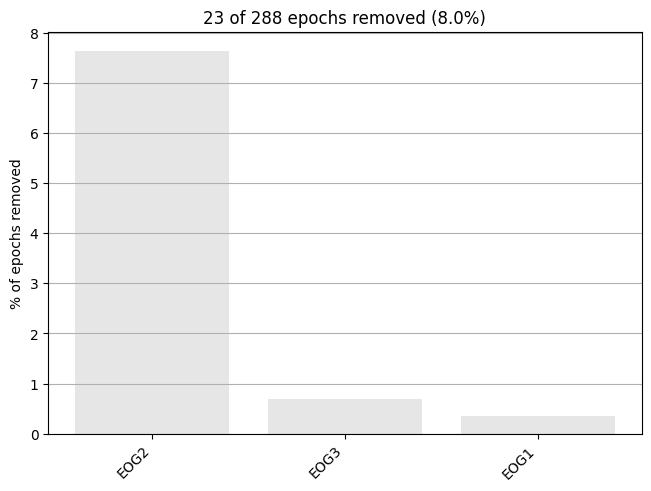

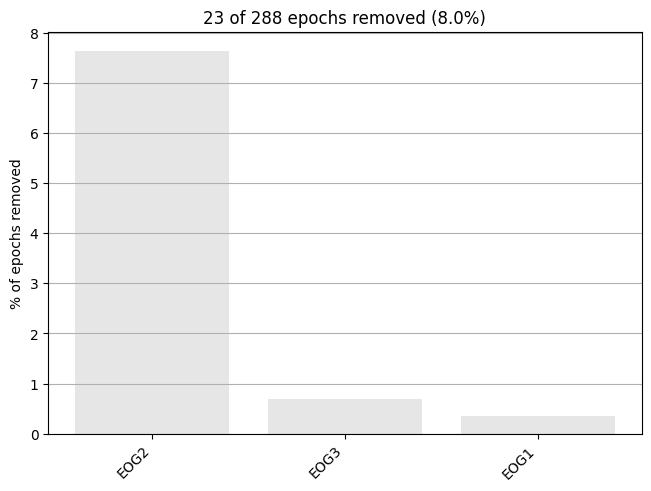

In [22]:
# ------------------------------
# 3. Inspect dropped epochs
# ------------------------------
print("Dropped epochs (per trial):")
print(epochs.drop_log[:20])  # show first 20 trial logs

# Plot summary of dropped epochs
epochs.plot_drop_log()


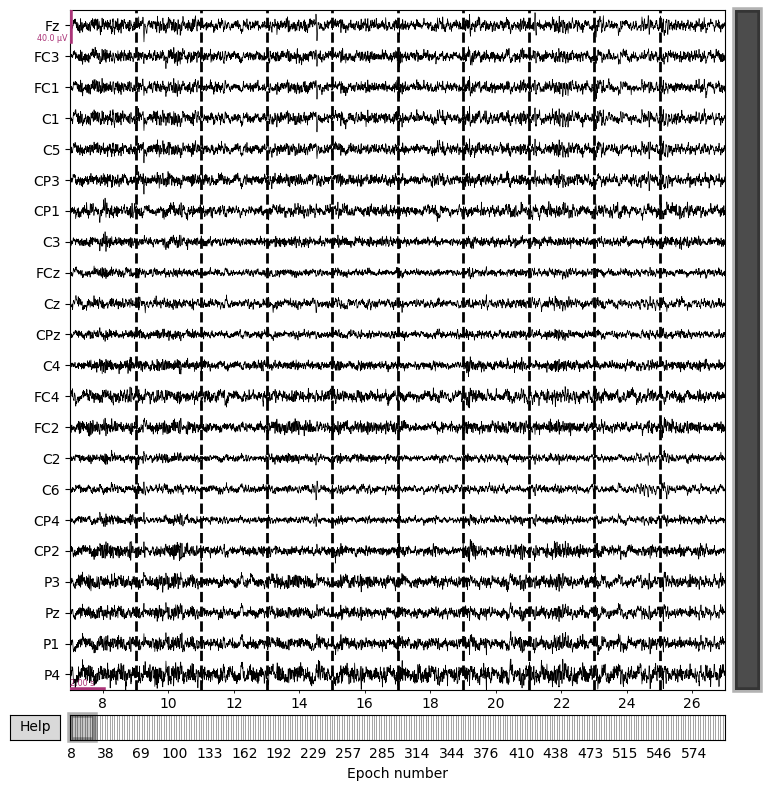

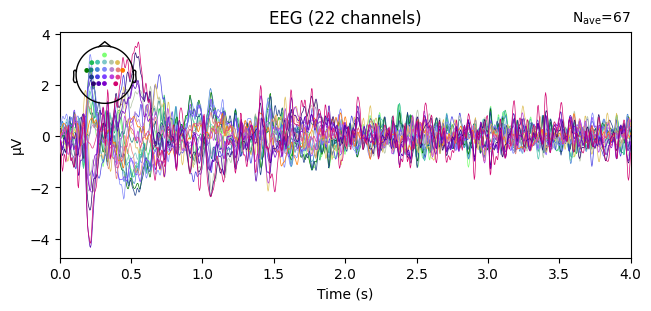

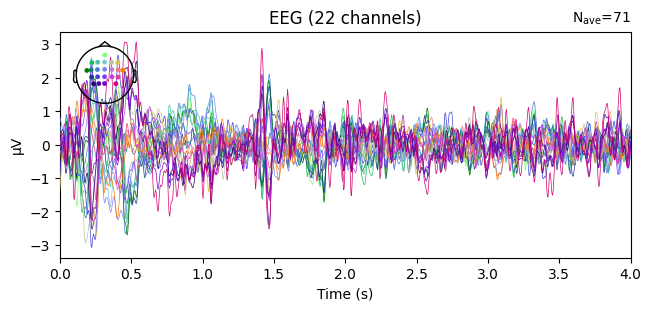

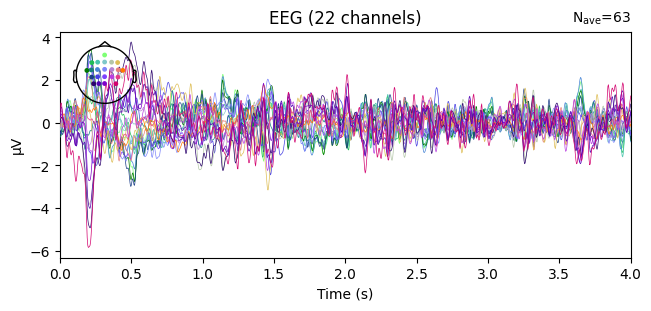

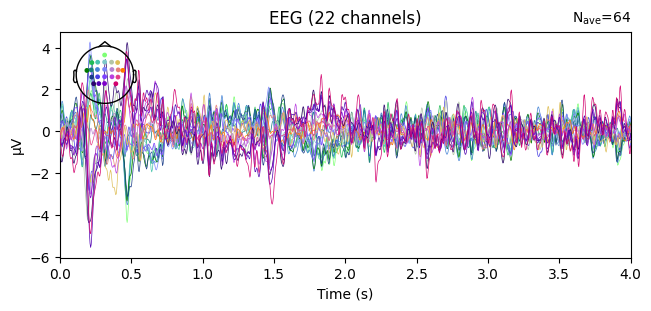

In [23]:
# ------------------------------
# 4. Inspect data
# ------------------------------
# Plot a few epochs to visually check quality
epochs.plot(n_epochs=10, n_channels=22)

# Plot averaged ERPs for each condition
for cond in event_ids.keys():
    epochs[cond].average().plot()

In [28]:
# ------------------------------
# 5. Export data for ML
# ------------------------------
X = epochs.get_data()        # shape: (trials, channels, timepoints)
y_raw = epochs.events[:, -1] # labels (e.g. 7,8,9,10)

# Map to consecutive integers (0=left, 1=right, 2=foot, 3=tongue)
label_map = {old: new for new, old in enumerate(event_ids.values())}
y = np.array([label_map[val] for val in y_raw])

print("Before balancing:")
for cls in np.unique(y):
    print(f"Class {cls}: {np.sum(y == cls)} trials")

# Balance classes
rng = np.random.default_rng(seed=42)  # reproducible
min_count = min([np.sum(y == cls) for cls in np.unique(y)])

X_balanced, y_balanced = [], []
for cls in np.unique(y):
    idx = np.where(y == cls)[0]
    chosen = rng.choice(idx, size=min_count, replace=False)
    X_balanced.append(X[chosen])
    y_balanced.append(y[chosen])

X_balanced = np.vstack(X_balanced)
y_balanced = np.hstack(y_balanced)

print("After balancing:")
for cls in np.unique(y_balanced):
    print(f"Class {cls}: {np.sum(y_balanced == cls)} trials")

print("X_balanced shape:", X_balanced.shape)
print("y_balanced shape:", y_balanced.shape)

# Save to disk
np.save("../data/features/A01T_X.npy", X_balanced)
np.save("../data/features/A01T_y.npy", y_balanced)

print("Features saved to ../data/features/")

Before balancing:
Class 0: 67 trials
Class 1: 71 trials
Class 2: 63 trials
Class 3: 64 trials
After balancing:
Class 0: 63 trials
Class 1: 63 trials
Class 2: 63 trials
Class 3: 63 trials
X_balanced shape: (252, 25, 1001)
y_balanced shape: (252,)
Features saved to ../data/features/
